<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#Outils" data-toc-modified-id="Outils-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Outils</a></span></li><li><span><a href="#Lecture-du-dataframe" data-toc-modified-id="Lecture-du-dataframe-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Lecture du dataframe</a></span></li></ul></li><li><span><a href="#Choix-d'un-modèle" data-toc-modified-id="Choix-d'un-modèle-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Choix d'un modèle</a></span><ul class="toc-item"><li><span><a href="#Roc-auc" data-toc-modified-id="Roc-auc-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Roc auc</a></span><ul class="toc-item"><li><span><a href="#split-des-données-en-Train-et-Test" data-toc-modified-id="split-des-données-en-Train-et-Test-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>split des données en Train et Test</a></span></li><li><span><a href="#Plot-de-la-courbe-ROC-pour-les-différents-modèles-testés" data-toc-modified-id="Plot-de-la-courbe-ROC-pour-les-différents-modèles-testés-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Plot de la courbe ROC pour les différents modèles testés</a></span></li></ul></li></ul></li><li><span><a href="#Bibliography" data-toc-modified-id="Bibliography-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bibliography</a></span></li></ul></div>

# Import


In [20]:
import numpy as np
import pandas as pd
import gc
import time
import re
from contextlib import contextmanager
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import joblib
import mlflow.sklearn



## Outils

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [5]:
def readdf(debug=True):
    savedataframe = "debugdataframe.csv" if debug else "apidataframe.csv"
    df = pd.read_csv(savedataframe)
    print("Reading",savedataframe)
    print("Shape",df.shape)
    return df

## Lecture du dataframe

In [6]:
df=readdf()
df.head(3)

Reading debugdataframe.csv
Shape (20000, 768)


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Choix d'un modèle

Je compare le LGBMClassifier avec d'autres classifiers.


In [34]:
classifiers = { 'Dummy Classifier': DummyClassifier(),
                'Logistic Regression': LogisticRegression(),
                'K Neighbors': KNeighborsClassifier(),
                'Random Forest': RandomForestClassifier(),
                'LGBM': LGBMClassifier()
              }

Pour les autres classifiers if faut imputer et scaler les données

In [35]:
preprocess  = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

## Roc auc

The Receiver Operating Characteristic (ROC) curve graphs the true positive rate versus the false positive rate:

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model.

The Area Under the Curve (AUC) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

### split des données en Train et Test


In [14]:
def prepare_train_df(df):
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    del df
    gc.collect()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_x, train_y = train_df[feats], train_df['TARGET']
    return train_x, train_y


In [17]:
X,y = prepare_train_df(df)


### Plot de la courbe ROC pour les différents modèles testés

In [36]:
def plot_roc_curve(classifiers, preprocessor, X, y, n_splits=10, fit=True):

    kf = KFold(n_splits=n_splits)    
    for clf_name, classifier in classifiers.items():
        print('Testing',clf_name)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            pipeline = Pipeline(
                    [
                     ('preprocessing', preprocessor),
                     ('clf', classifier)
                    ]
            )
            
            if fit :
                pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)
            print(' Auc fold',i,":",auc_)
            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=clf_name + r' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


Testing Dummy Classifier
 Auc fold 0 : 0.5
 Auc fold 1 : 0.5
 Auc fold 2 : 0.5
 Auc fold 3 : 0.5
 Auc fold 4 : 0.5
 Auc fold 5 : 0.5
 Auc fold 6 : 0.5
 Auc fold 7 : 0.5
 Auc fold 8 : 0.5
 Auc fold 9 : 0.5
Testing Logistic Regression


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 0 : 0.5530414746543779
 Auc fold 1 : 0.5016216216216216
 Auc fold 2 : 0.5046447040796782
 Auc fold 3 : 0.5251638412802192
 Auc fold 4 : 0.4849864130434783


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 5 : 0.5279353690416597


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 6 : 0.4492690408183366


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 7 : 0.535366042408296


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 8 : 0.5215760869565217


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 9 : 0.5987111480069227
Testing K Neighbors
 Auc fold 0 : 0.5586175115207372
 Auc fold 1 : 0.5555603603603603
 Auc fold 2 : 0.5300050277724574
 Auc fold 3 : 0.5437506810504522
 Auc fold 4 : 0.5670040760869566
 Auc fold 5 : 0.5078424828967129
 Auc fold 6 : 0.5521098619690169
 Auc fold 7 : 0.5565983312462186
 Auc fold 8 : 0.5895652173913044
 Auc fold 9 : 0.5471852091570402
Testing Random Forest
 Auc fold 0 : 0.7200691244239631
 Auc fold 1 : 0.7179027027027026
 Auc fold 2 : 0.6994230032560812
 Auc fold 3 : 0.6551394012982767
 Auc fold 4 : 0.7091168478260871
 Auc fold 5 : 0.7252975693865065
 Auc fold 6 : 0.7314586821629074
 Auc fold 7 : 0.712301782724318
 Auc fold 8 : 0.6595312499999999
 Auc fold 9 : 0.6792362567010454
Testing LGBM
 Auc fold 0 : 0.7472811059907833
 Auc fold 1 : 0.729499099099099
 Auc fold 2 : 0.6899061482474622
 Auc fold 3 : 0.6726599106461807
 Auc fold 4 : 0.745991847826087
 Auc fold 5 : 0.7324517492630291
 Auc fold 6 : 0.7308184772973505
 Auc fold 7 : 0.74975728

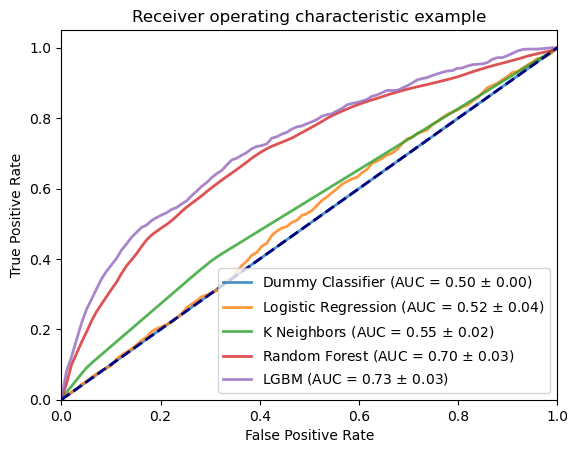

In [37]:
plot_roc_curve(classifiers, preprocess, X,y)

Le classifier LGBM du kernel choisi se confirme le meilleur.

# Bibliography

Light gbm

https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html


Auc Roc

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

